# Test idea

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import torch
import torch.nn as nn
import clip
from PIL import Image
from transformers import AutoModelForCausalLM

In [ ]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


# Load image
IMAGE_PATH = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/HE/A4_TMA_15_02_IB_HE.png"


# configs

## VisionLanguageProjector - MLP

In [8]:
# Define the Vision-Language Projector (MLP)
class VisionLanguageProjector(nn.Module):
    def __init__(self, input_dim=512, output_dim=512):  # Matching CLIP text embedding dim
        super(VisionLanguageProjector, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)  # Align with CLIP text embeddings
        )

    def forward(self, x):
        return self.mlp(x)

## CLIP

In [19]:
# Load and preprocess the style image
style_image_path = IMAGE_PATH
style_image = Image.open(style_image_path).convert("RGB")
style_tensor = preprocess(style_image).unsqueeze(0).to(device)

# Extract features using CLIP image encoder
with torch.no_grad():
    image_features = model.encode_image(style_tensor)

# Normalize the image features (similar to text embeddings)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# Pass through Vision-Language Projector
vl_projector = VisionLanguageProjector(input_dim=512, output_dim=256).to(device)
style_embedding = vl_projector(image_features)

print("Transformed Style Embedding Shape:", style_embedding.shape)  # Should match text embeddings

Transformed Style Embedding Shape: torch.Size([1, 256])


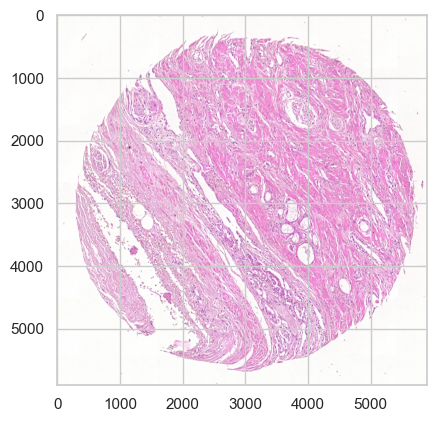

In [20]:
plt.imshow(style_image)

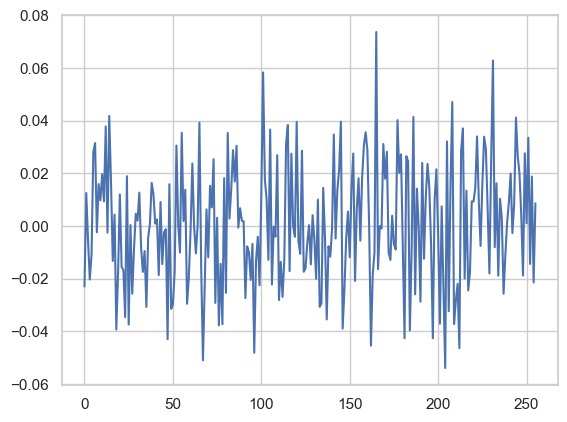

In [22]:
plt.plot(style_embedding[0].detach().numpy())

**Note**: Style embedding successfully extracted

## moondream

In [ ]:
# Set the device to GPU if available, else fallback to MPS or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Load the model and move it to the selected device
model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-01-09",
    trust_remote_code=True,
)

model = model.to(device)

# Open the image and also move it to the same device
image = Image.open(IMAGE_PATH)

# Assuming the model.encode_image method handles image tensor transformation,
# make sure that the image is passed correctly to the model
enc_image = model.encode_image(image)

# Now, you can query the model for the description
print(model.query(enc_image, "Describe this image."))

# Best answer: {'answer': ' The image presents a close-up view of a circular, pink tissue sample. The tissue exhibits a complex pattern of pink and white stripes and swirls, with some areas appearing more densely populated with pink cells than others. The pink cells are not uniformly distributed throughout the tissue, with some areas showing a more even distribution of pink cells. The white areas within the tissue appear to be a lighter shade of pink, possibly indicating a contrast or a different type of cell structure. The image is taken from a slightly elevated angle, providing a comprehensive view of the tissue sample.'}

{'answer': ' The image presents a close-up view of a circular, pink tissue sample. The tissue exhibits a complex pattern of pink and white stripes and swirls, with some areas appearing more densely populated with pink cells than others. The pink cells are not uniformly distributed throughout the tissue, with some areas showing a more even distribution of pink cells. The white areas within the tissue appear to be a lighter shade of pink, possibly indicating a contrast or a different type of cell structure. The image is taken from a slightly elevated angle, providing a comprehensive view of the tissue sample.'}


---
# Generative Backbone

(Text to Image Generation)